In [1]:
!pwd

/reg/data/ana03/scratch/cwang31/spi


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [3]:
import os
import logging
import torch
import socket
import pickle
import tqdm

from deepprojection.datasets.lite    import SPIDataset         , SPIOnlineDataset
from deepprojection.model            import OnlineSiameseModel , ConfigSiameseModel
from deepprojection.trainer          import OnlineTrainer      , ConfigTrainer
from deepprojection.validator        import OnlineLossValidator, ConfigValidator
from deepprojection.encoders.convnet import Hirotaka0122       , ConfigEncoder
from deepprojection.utils            import EpochManager       , MetaLog, init_logger, split_dataset, set_seed
from datetime import datetime
from image_preprocess_faulty import DatasetPreprocess

# [[[ SEED ]]]
seed = 0
set_seed(seed)


# [[[ CONFIG ]]]
timestamp_prev = None
frac_train     = 0.5
frac_validate  = 0.5

logs_triplets = True

lr = 1e-3
## lr = 5e-4

## alpha = 0.02
## alpha = 0.03336201
alpha = 0.05565119
## alpha = 0.09283178
## alpha = 0.15485274
## alpha = 0.25830993
## alpha = 0.43088694
## alpha = 0.71876273
## alpha = 1.1989685
## alpha = 2.0

size_sample_per_class_train    = 6
## size_sample_per_class_train    = 10
## size_sample_per_class_train    = 20
## size_sample_per_class_train    = 40
## size_sample_per_class_train    = 60
size_sample_train              = size_sample_per_class_train * 100
size_sample_validate           = size_sample_train // 2
size_sample_per_class_validate = size_sample_per_class_train // 2
size_batch                     = 20
trans                          = None

# [[[ LOGGING ]]]
timestamp = init_logger(log_name = 'train', returns_timestamp = True)
print(timestamp)

# Clarify the purpose of this experiment...
hostname = socket.gethostname()
comments = f"""
            Hostname: {hostname}.

            Online training.

            Sample size (train)               : {size_sample_train}
            Sample size (validate)            : {size_sample_validate}
            Sample size (per class, train)    : {size_sample_per_class_train}
            Sample size (per class, validate) : {size_sample_per_class_validate}
            Batch  size                       : {size_batch}
            Alpha                             : {alpha}
            lr                                : {lr}

            """

# Create a metalog to the log file, explaining the purpose of this run...
metalog = MetaLog( comments = comments )
metalog.report()


# [[[ DATASET ]]]
# Set up parameters for an experiment...
drc_dataset   = 'fastdata'
fl_dataset    = '0000.fastdata'    # Raw, just give it a try
path_dataset  = os.path.join(drc_dataset, fl_dataset)

# Load raw data...
with open(path_dataset, 'rb') as fh:
    dataset_list = pickle.load(fh)

# Split data...
data_train   , data_val_and_test = split_dataset(dataset_list     , frac_train   , seed = None)
data_validate, data_test         = split_dataset(data_val_and_test, frac_validate, seed = None)

# Define the training set
dataset_train = SPIOnlineDataset( dataset_list          = data_train, 
                                  size_sample           = size_sample_train,
                                  size_sample_per_class = size_sample_per_class_train, 
                                  trans                 = trans, 
                                  seed                  = None, )
dataset_train.report()

# Define the training set
dataset_validate = SPIOnlineDataset( dataset_list          = data_validate, 
                                     size_sample           = size_sample_train,
                                     size_sample_per_class = size_sample_per_class_validate, 
                                     trans                 = trans, 
                                     seed                  = None, )
dataset_validate.report()

2022_1129_2242_47


In [ ]:
[ len(dataset_train.label_seqi_dict[i]) for i in range(3) ]

In [ ]:
for i, item in enumerate(dataset_validate):
    if i > 10: break
    print(item[2])

In [ ]:
for i, item in enumerate(dataset_validate):
    if i > 10: break
    print(item[2])

In [ ]:
dataset_train[0]

### Preprocess

In [4]:
# Preprocess dataset...
# Data preprocessing can be lengthy and defined in dataset_preprocess.py
img_orig            = dataset_train[0][0][0]   # idx, fetch img
dataset_preproc     = DatasetPreprocess(img_orig)
trans               = dataset_preproc.config_trans()
dataset_train.trans = trans
dataset_validate.trans = trans
img_trans           = dataset_train[0][0][0]

In [5]:
dataset_train.cache_dataset()
dataset_validate.cache_dataset()

#### Just checking

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.figure(figsize = (5, 3))
data = img_orig
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

In [ ]:
plt.figure(figsize = (5, 3))
data = dataset_train[0][0][0]
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

In [ ]:
for j in range(20):
    for _ in range(1):
        plt.figure(figsize = (5, 3))
        #data = img_orig
        data = dataset_train[j][0][0]
        vmin = data.mean()
        vmax = vmin + 1 * data.std()
        plt.imshow(data, vmin = vmin, vmax = vmax)
        plt.colorbar()

### Load model

In [7]:
# [[[ IMAGE ENCODER ]]]
# Config the encoder...
dim_emb        = 128
size_y, size_x = img_trans.shape[-2:]
config_encoder = ConfigEncoder( dim_emb = dim_emb,
                                size_y  = size_y,
                                size_x  = size_x,
                                isbias  = True )
encoder = Hirotaka0122(config_encoder)


# [[[ MODEL ]]]
# Config the model...
config_siamese = ConfigSiameseModel( alpha = alpha, encoder = encoder, )
model = OnlineSiameseModel(config_siamese)
model.init_params(from_timestamp = timestamp_prev)

### Config trainer and validator

In [8]:
# [[[ CHECKPOINT ]]]
drc_cwd          = os.getcwd()
DRCCHKPT         = "chkpts"
prefixpath_chkpt = os.path.join(drc_cwd, DRCCHKPT)
fl_chkpt         = f"{timestamp}.train.chkpt"
path_chkpt       = os.path.join(prefixpath_chkpt, fl_chkpt)


# [[[ TRAINER ]]]
# Config the trainer...
config_train = ConfigTrainer( path_chkpt        = path_chkpt,
                              num_workers       = 1,
                              batch_size        = size_batch,
                              pin_memory        = True,
                              shuffle           = False,
                              logs_triplets     = logs_triplets,
                              method            = 'random-semi-hard', 
                              lr                = lr, 
                              tqdm_disable      = True)
trainer = OnlineTrainer(model, dataset_train, config_train)


# [[[ VALIDATOR ]]]
config_validator = ConfigValidator( path_chkpt        = None,
                                    num_workers       = 1,
                                    batch_size        = size_batch,
                                    pin_memory        = True,
                                    shuffle           = False,
                                    logs_triplets     = logs_triplets,
                                    method            = 'random-semi-hard', 
                                    lr                = lr,
                                    tqdm_disable      = True)  # Conv2d input needs one more dim for batch
validator = OnlineLossValidator(model, dataset_validate, config_validator)

### Find learning rates

In [9]:
lr_exponent_list = torch.linspace(-8,1,1000)

In [10]:
from torch.utils.data.dataloader import DataLoader

# Turn on training mode...
model.train()
dataset = dataset_train
loader_train = DataLoader( dataset, shuffle     = config_train.shuffle, 
                                    pin_memory  = config_train.pin_memory, 
                                    batch_size  = config_train.batch_size,
                                    num_workers = config_train.num_workers )

In [11]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [12]:
import random

loader_train_list = list(loader_train)

avg_loss = 0.0
beta = 0.98
loss_vs_lr_exponent_list = []
for i, lr_exponent in enumerate(lr_exponent_list):
    lr = 10**lr_exponent
    
    # print(f"Processing {i}, {lr}...")
    config_train.lr = lr
    optimizer = model.configure_optimizers(config_train)
    
    idx_rand = random.randrange(0, len(loader_train))
    data = loader_train_list[idx_rand]
    batch_imgs, batch_labels, batch_metadata = data
    batch_imgs = batch_imgs.to(device, dtype = torch.float)
    
    loss = model.forward(batch_imgs, batch_labels, batch_metadata, 
                         logs_triplets = config_train.logs_triplets, 
                         method = config_train.method,)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    avg_loss = beta * avg_loss + (1-beta) *loss.item()
    smoothed_loss = avg_loss / (1 - beta**(i+1))
    
    # loss_vs_lr_exponent_list.append((lr.item(), loss.item()))
    loss_vs_lr_exponent_list.append((lr_exponent.item(), smoothed_loss))

In [13]:
loss_vs_lr_exponent_list[0]

(tensor(-8.), 0.09719862788915634)

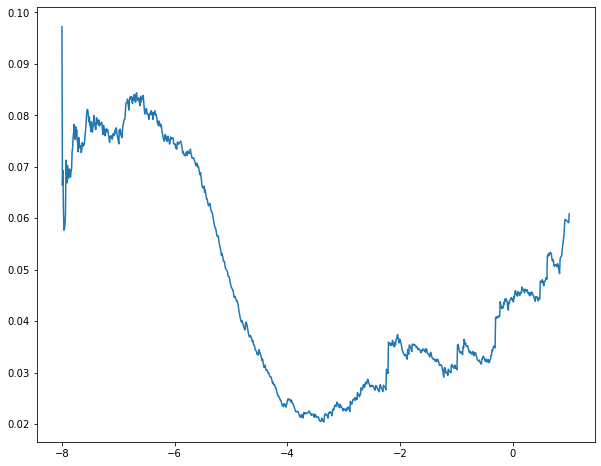

In [14]:
import numpy as np

x = np.array([ lr for lr, _ in loss_vs_lr_exponent_list ])
y = np.array([ loss for _, loss in loss_vs_lr_exponent_list ])

plt.figure(figsize = (10, 8))
plt.plot(x, y)
# plt.xlim(0, 2e-1)